**Introduction and Motivation**  -- What were you trying to do  and WHY?
  - For full points clearly state the problem and why it is important. (approx 2 points)

**Related work**
- Mention any related work from our class readings or from other literature.
This can be something as general as discussing generalization/overfitting or whether you are using parametric or non-parametric methods …. (You do not have to use the methods taught in class. You do not have to do unsupervised learning).

- For full credit also mention a paper in the literature that addresses this problem
(or if there is nothing like it in the literature make the case for why your problem is unique). (approx 2 points)  


**Methods**
- What did you do?  Be as precise as you can.   For full credit there should be enough detail for someone relatively skilled to replicate your work.  (approx 7 points)

Batteries 49, 50, 51, 52 experiments ended early, can use data from other batteries to predict their EOL


Predict remaining charge capacity for a given discharge cycle

Predict remaining useful life

Potentially:
- Group data points on a temperature vs remaining charge capacity graph
- Clustering on a cycle vs charge capacity graph (different clustering algorithms here)
- SOH is just capacity / max capacity, each battery has its own set of Re and Rct values and we can see how it changes over cycling, then can try to predict state of health or remaining useful cycles left 
- Look to see what cells stop at 2.3V and then use that to predict remaining discharge capacity for those at 2.5V and 2.7V

**Results**
- What did you discover? How well did it work?  As this is a class project, it is likely that many things did not work as well as planned.  For this project, detailing what went wrong is as important as describing what went well.  (approx 7 points)

**Discussion**
- What did you learn?  What could you do better? (What would you
have done next if you had more time)?.....  Why do you think it didn't work if it didn't?  

- If everything worked perfectly,  what next steps would you suggest for follow-up work.  For full credit discuss two extensions or improvements to your project with short justifications for why you think that would work better (improvements) or why they are promising extensions. (approx 7 points) 

In [8]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
# Read in the dataset and take a look at the first few rows
battery_df = pd.read_csv('./cleaned_dataset/metadata.csv')
battery_df.head(5)

,type,start_time,ambient_temperature,battery_id,test_id,uid,filename,Capacity,Re,Rct
0,discharge,[2010. 7. 21. 15. 0. ...,4,B0047,0,1,00001.csv,1.6743047446975208,NaN,NaN
1,impedance,[2010. 7. 21. 16. 53. ...,24,B0047,1,2,00002.csv,NaN,0.05605783343888099,0.20097016584458333
2,charge,[2010. 7. 21. 17. 25. ...,4,B0047,2,3,00003.csv,NaN,NaN,NaN
3,impedance,[2010 7 21 20 31 5],24,B0047,3,4,00004.csv,NaN,0.05319185850921101,0.16473399914864734
4,discharge,[2.0100e+03 7.0000e+00 2.1000e+01 2.1000e+01 2...,4,B0047,4,5,00005.csv,1.5243662105099023,NaN,NaN


## Using Unsupervised ML Algorithms to Determine Battery Groups in the Experiment
We will use a multitude of different clustering algorithms, including:
- K-Means
- Stochastic K-Means
- Mixture of Gaussians
- Spectral Clustering

to attempt to cluster data points from batteries of the same experiment group.

We will examine how well each of the clustering algorithms work in producing the correct clusters based on the data points generated by each of the experiments.

## Actual Battery Groups
First off, we will look at what the actual data and graphs look like for batteries belonging to each group in the experiment. This will help us determine the success of each of the different clustering algorithms.

In [10]:
battery_groups = {"1": ["B0025", "B0026", "B0027", "B0028"],
                "2b": ["B0029", "B0030", "B0031", "B0032"],
                "2c": ["B0033", "B0034", "B0036"],
                "2d": ["B0038", "B0039", "B0040"],
                "2e": ["B0041", "B0042", "B0043", "B0044"],
                "3": ["B0045", "B0046", "B0047", "B0048"],
                "4": ["B0049", "B0050", "B0051", "B0052"],
                "5": ["B0053", "B0054", "B0055", "B0056"],
                "6": ["B0005", "B0006", "B0007", "B0018"]}

### Plotting Each Battery's Graph
We will graph Capacity vs Cycle count for each of the batteries used in the experiment.

In [11]:
### Helper Functions
'''
Function to try to transform a value to a float
@param x: value to transform
@return: float value of x if possible, 0 otherwise
'''
def try_float(x):
    try:
        return float(x)
    except:
        return None

'''
Function to get battery data for a specific battery_id

@param battery_data: dataframe with battery data
@param battery_id: battery_id to get data for
@return: dataframe with 'Capacity' and 'Cycle' columns
'''
def get_battery_data(battery_data, battery_id):
    # Put non-null Capacity values of battery with battery_id B0047 into a dataframe
    df_batt = battery_data[battery_data['battery_id'] == battery_id]
    df_batt = pd.DataFrame(df_batt[df_batt['Capacity'].notnull()]['Capacity'])

    # Return None if dataframe is empty
    if (df_batt.empty):
        return None

    # Go through and transform all 'Capacity' values to float
    df_batt['Capacity'] = df_batt['Capacity'].apply(try_float)

    # Drop all rows with Capacity = None (failed to convert to float)
    df_batt = df_batt[df_batt['Capacity'] != None]

    # Reset index
    df_batt.reset_index(drop=True, inplace=True)

    # Add 'Cycle' column starting from 0
    df_batt['Cycle'] = np.arange(len(df_batt))

    return df_batt

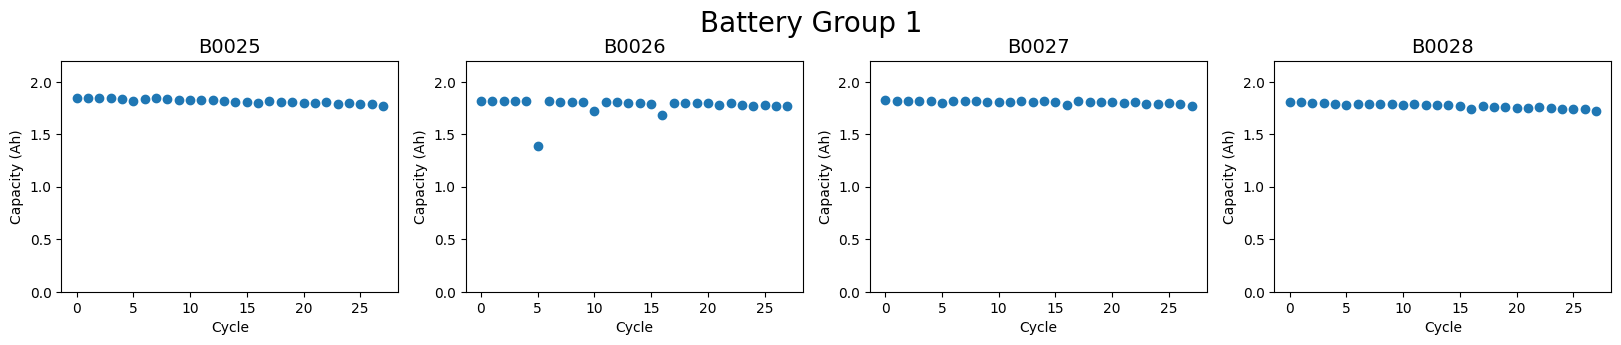

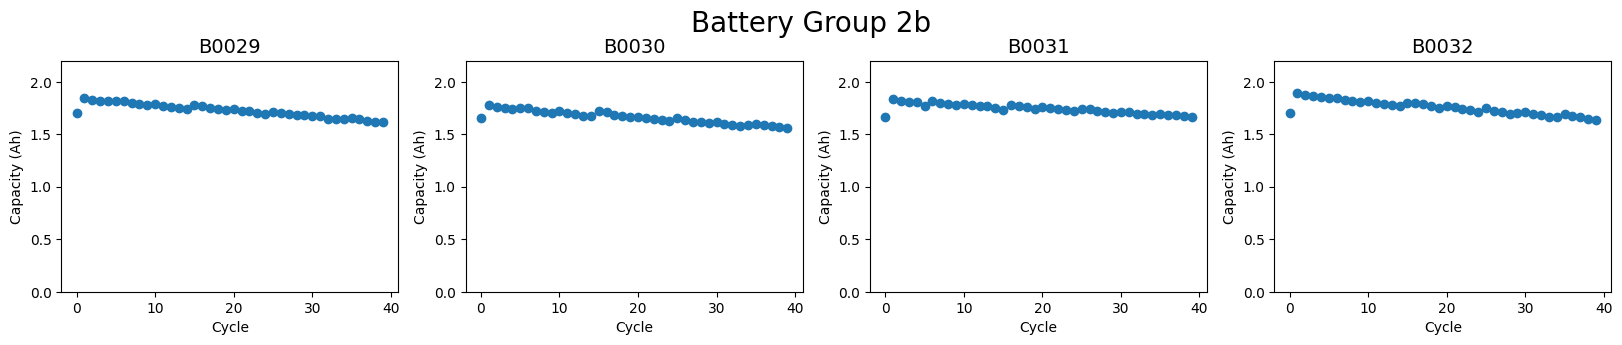

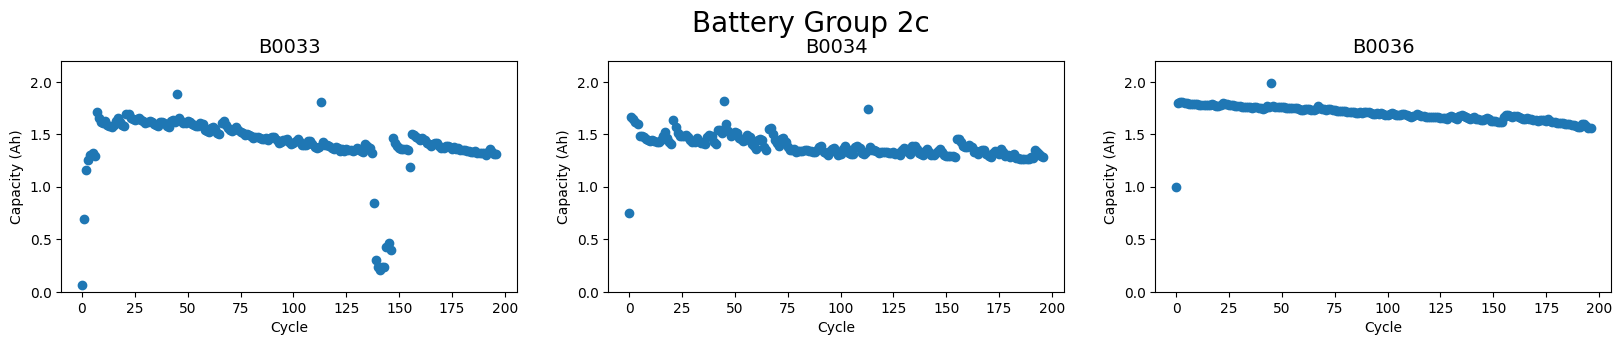

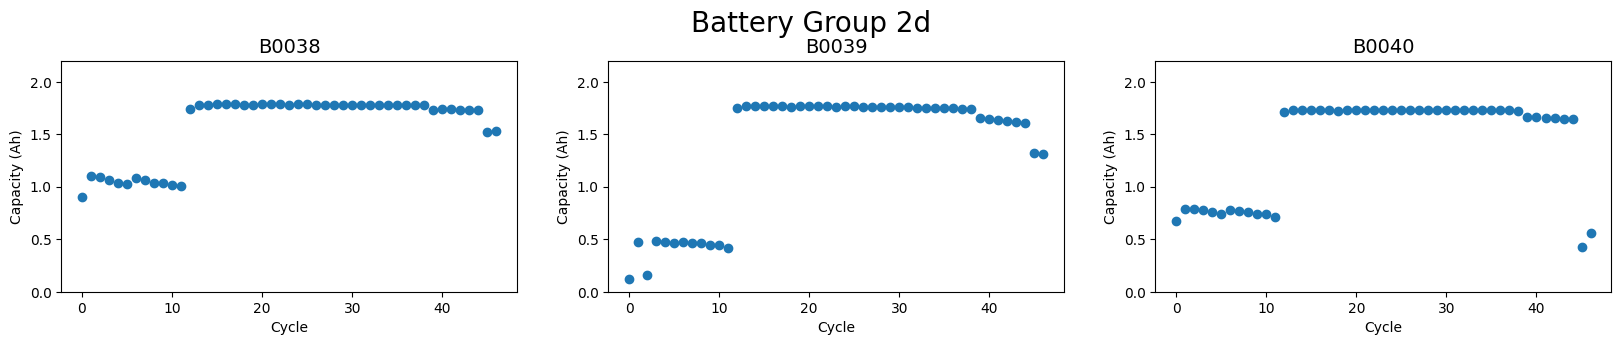

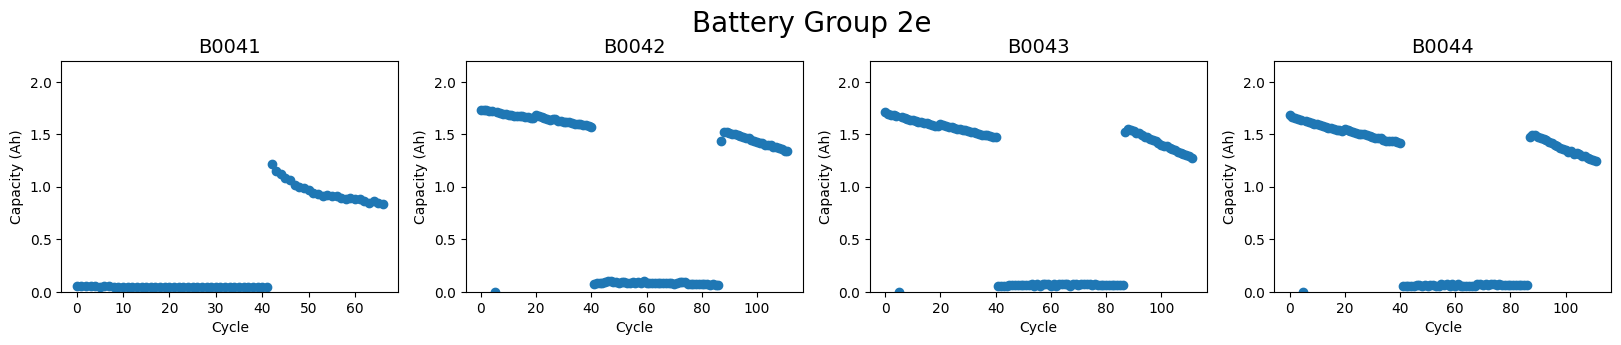

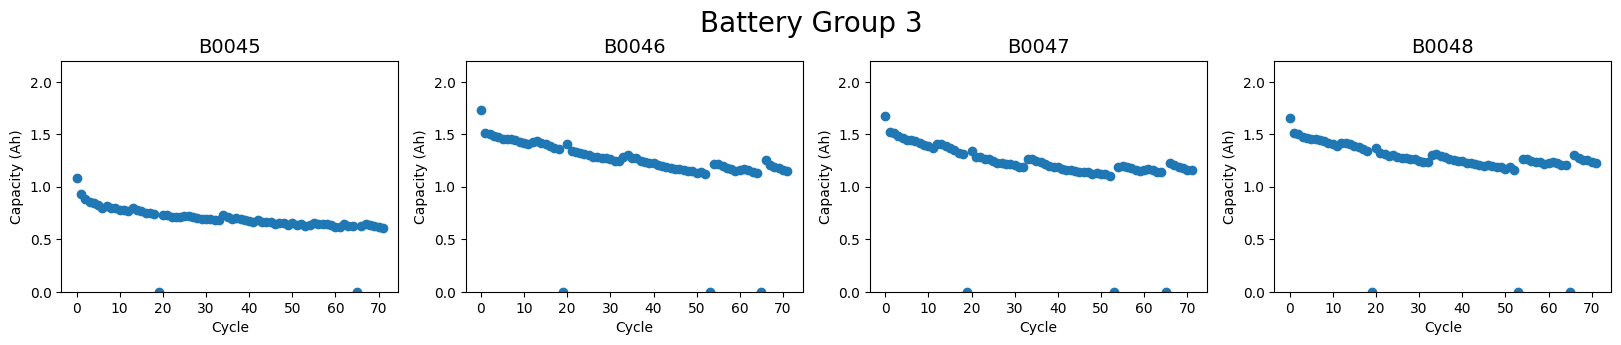

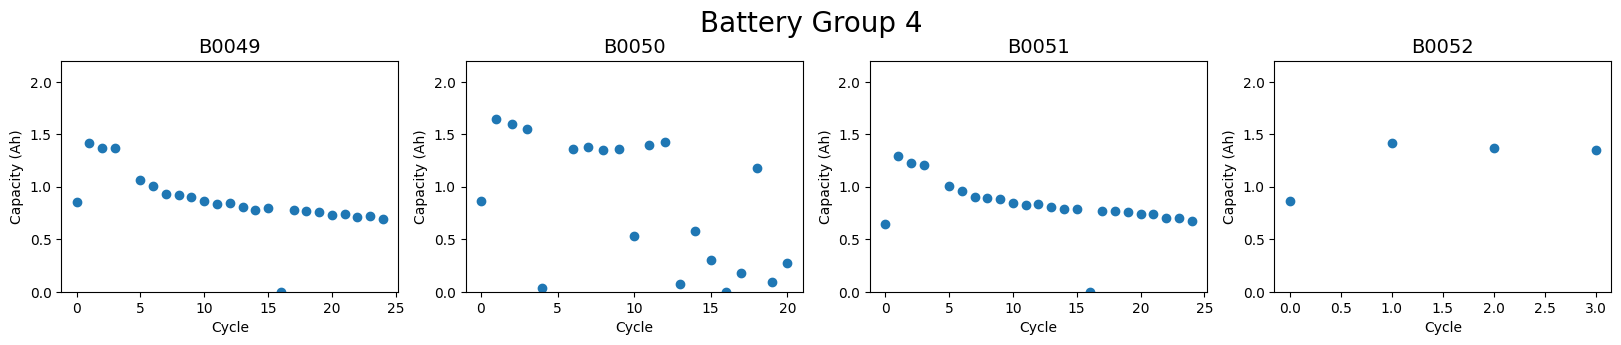

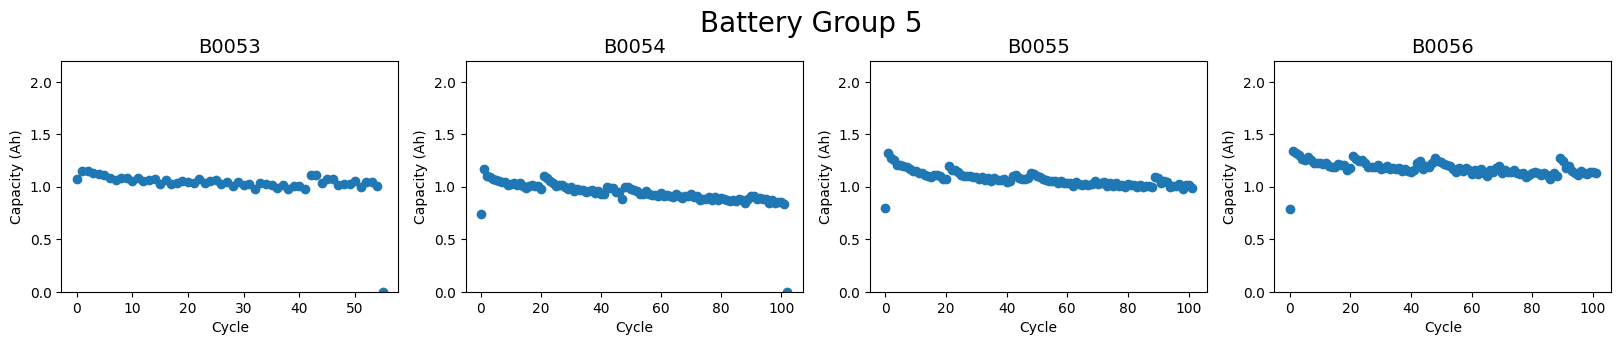

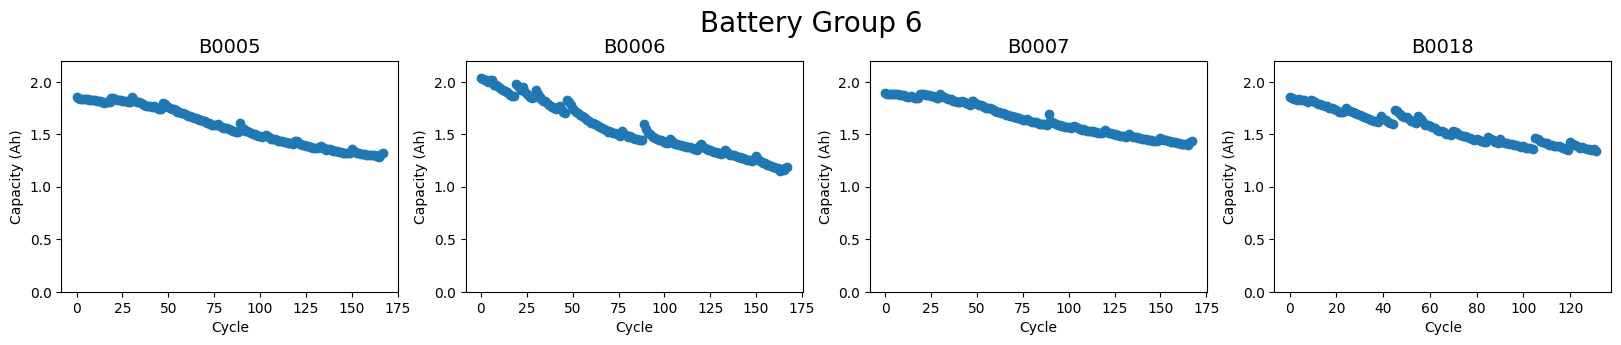

In [12]:
'''
Iterate through all battery groups and plot the capacity vs cycle for each battery in the group
'''
for (batt_group, batteries) in battery_groups.items():
    fig, axs = plt.subplots(1, len(batteries), figsize=(20, 3))
    fig.suptitle('Battery Group ' + batt_group, fontsize=20, y=1.05)
    for ax, battery in zip(axs, batteries):
        df_batt = get_battery_data(battery_df, battery)
        if (df_batt is None):
            continue

        ax.scatter(df_batt['Cycle'], df_batt['Capacity'], label=battery)
        ax.set_title(battery, fontsize=14)
        ax.set_xlabel('Cycle')
        ax.set_ylabel('Capacity (Ah)')
        ax.set_ylim(0, 2.2)
    plt.show()

Plotting the graphs of each battery in each experiment group reveals distinct graph shapes. If we were to mix up the individual graphs, picking out which graph belongs to which experiment group would be on the easier side.

### Plot All Data Points on the Same Graph
We will now plot all of the above data points onto the same graph in preparation for the use of clustering algorithms.

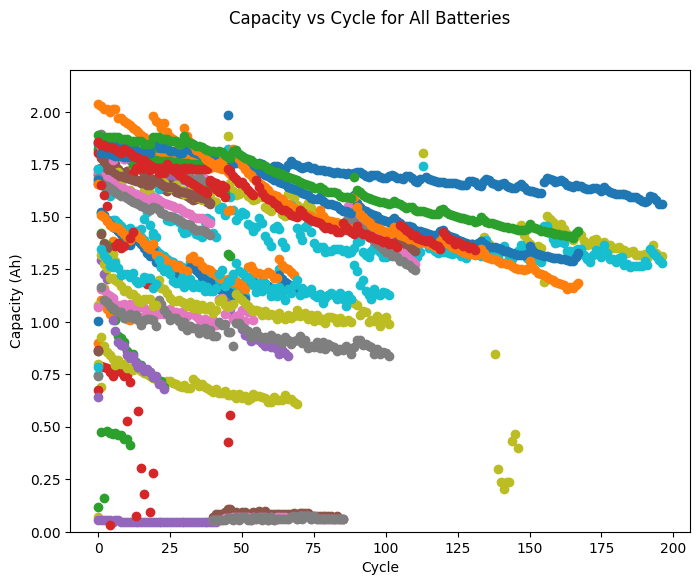

In [13]:
# Plotting all onto one graph
plt.figure(figsize=(8,6))
plt.suptitle('Capacity vs Cycle for All Batteries')
plt.xlabel('Cycle')
plt.ylabel('Capacity (Ah)')

for batt_group in battery_groups:
    for batt_id in battery_groups[batt_group]:
        # Put non-null Capacity values of battery with battery_id B0047 into a dataframe
        df_batt = battery_df[battery_df['battery_id'] == batt_id]
        df_batt = pd.DataFrame(df_batt[df_batt['Capacity'].notnull()]['Capacity'])

        if (df_batt.empty):
            continue

        # Go through and transform all 'Capacity' values to float
        df_batt['Capacity'] = df_batt['Capacity'].apply(try_float)

        # Drop all rows with 'Capacity' values that are 0
        df_batt = df_batt[df_batt['Capacity'] != 0]

        # Reset index
        df_batt.reset_index(drop=True, inplace=True)

        # Add 'Cycle' column starting from 0
        df_batt['Cycle'] = np.arange(len(df_batt))

        plt.scatter(df_batt['Cycle'], df_batt['Capacity'], label=batt_id)
        plt.ylim(0, 2.2)

plt.show()

In [14]:
# Get and sort battery ids
batt_ids = battery_df['battery_id'].unique()
batt_ids = np.sort(batt_ids)

In [15]:
# create variable that has all of the cycle and capacity data grouped together
grouped_df = pd.DataFrame({'Cycle': pd.Series(dtype='int'), 'Capacity': pd.Series(dtype='float')})
for batt_id in batt_ids:
    data = get_battery_data(battery_df, batt_id)
    grouped_df = pd.concat([grouped_df, data], ignore_index=True)

In [18]:
# Make functions for K-means algorithm
def plotCurrent(X, Rnk, Kmus):
    N, D = np.shape(X)
    K = np.shape(Kmus)[0]

    InitColorMat = np.matrix([
        [1, 0, 0],  # Red
        [0, 1, 0],  # Green
        [0, 0, 1],  # Blue
        [0, 0, 0],  # Black
        [1, 1, 0],  # Yellow
        [1, 0, 1],  # Magenta
        [0, 1, 1],  # Cyan
        [0.5, 0.5, 0.5],  # Gray
        [1, 0.5, 0]  # Orange
    ])

    # Select colors for the current number of clusters
    KColorMat = InitColorMat[:K]  # Slice up to the number of clusters (K)
    colorVec = Rnk.dot(KColorMat)  # Assign colors to points
    muColorVec = np.eye(K).dot(KColorMat)  # Assign colors to centroids

    # Plot data points as smaller solid circles
    plt.scatter(X[:, 0], X[:, 1], c=colorVec, marker='o', s=10, alpha=0.7)

    # Plot centroids as larger diamonds
    plt.scatter(Kmus[:, 0], Kmus[:, 1], c=muColorVec, marker='D', s=50)


def calcSqDistances(X, Kmus):
    # YOUR CODE HERE
    x_squared = np.sum(X**2, axis=1)
    Kmus_squared = np.sum(Kmus**2, axis=1)
    cross = np.dot(X, Kmus.T)
    sqDmat = x_squared[:,None]+Kmus_squared-2*cross
    return sqDmat

def determineRnk(sqDmat):
    # YOUR CODE HERE
    N, K = sqDmat.shape
    min_indicies = np.argmin(sqDmat, axis=1)
    Rnk = np.eye(K)[min_indicies]
    return Rnk

def recalcMus(X, Rnk):
    # YOUR CODE HERE
    Nk = np.sum(Rnk,axis=0)
    w_sum = np.dot(Rnk.T, X)
    Kmus = np.divide(w_sum, Nk[:,None])
    return Kmus

def runKMeans(K, df):
    fig = plt.gcf()

    # Convert DataFrame to NumPy array
    X = df.to_numpy()

    # Determine and store data set information
    N, D = X.shape

    # Allocate space for the K mu vectors
    Kmus = np.zeros((K, D))

    # Initialize cluster centers by randomly picking points from the data
    rand_inds = np.random.permutation(N)
    Kmus = X[rand_inds[:K], :]

    # Specify the maximum number of iterations to allow
    maxiters = 1000

    # Initialize variables for plotting
    plot_iterations = [0]  # Start with the first iteration
    sqDmat = None  # To store squared distances
    Rnk = None  # Responsibility matrix

    for iter in range(maxiters):
        # Calculate squared distance matrix
        sqDmat = calcSqDistances(X, Kmus)

        # Assign each data vector to the closest mu vector
        Rnk = determineRnk(sqDmat)

        KmusOld = Kmus

        # Plot at the first, middle, and last iterations
        if iter == 0:  # First iteration
            plotCurrent(X, Rnk, Kmus)
            plt.show()
        elif iter == maxiters // 2:  # Middle iteration
            plot_iterations.append(iter)
            plotCurrent(X, Rnk, Kmus)
            plt.show()

        # Recalculate mu values based on cluster assignments
        Kmus = recalcMus(X, Rnk)

        # Check convergence
        if sum(abs(KmusOld.flatten() - Kmus.flatten())) < 1e-6:
            plot_iterations.append(iter)
            break

    # Plot the last iteration
    plotCurrent(X, Rnk, Kmus)
    plt.show()

    return Kmus

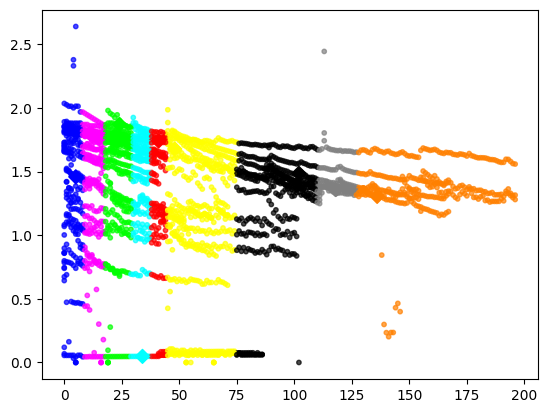

/var/folders/sc/_5mj781j5315nzv10s8kvs1w0000gn/T/ipykernel_68214/4100783193.py:49: RuntimeWarning: invalid value encountered in divide
  Kmus = np.divide(w_sum, Nk[:,None])


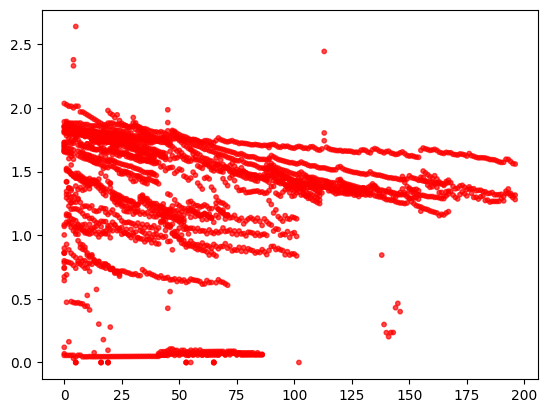

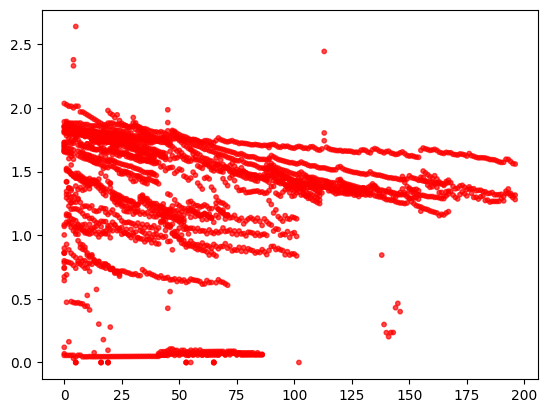

array([[59.37759485,         nan],
       [        nan,         nan],
       [        nan,         nan],
       [        nan,         nan],
       [        nan,         nan],
       [        nan,         nan],
       [        nan,         nan],
       [        nan,         nan],
       [        nan,         nan]])

In [19]:
# Run K-Means on the Data
runKMeans(9, grouped_df)

In [ ]:
df_00001 = pd.read_csv('./cleaned_dataset/data/00001.csv')
# Create a 1x3 subplot layout for the three plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Voltage vs. Time
axes[0].plot(df_00001['Time'], df_00001['Voltage_measured'], color='blue')
axes[0].set_title('Voltage vs. Time')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Voltage (V)')
axes[0].grid(True, linestyle='--', alpha=0.7)

# Plot 2: Current vs. Time
axes[1].plot(df_00001['Time'], df_00001['Current_measured'], color='orange')
axes[1].set_title('Current vs. Time')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Current (A)')
axes[1].grid(True, linestyle='--', alpha=0.7)

# Plot 3: Temperature vs. Time
axes[2].plot(df_00001['Time'], df_00001['Temperature_measured'], color='green')
axes[2].set_title('Temperature vs. Time')
axes[2].set_xlabel('Time (s)')
axes[2].set_ylabel('Temperature (°C)')
axes[2].grid(True, linestyle='--', alpha=0.7)

# Adjust layout for better appearance
plt.tight_layout()
plt.show()


In [ ]:
df_00003 = pd.read_csv('./cleaned_dataset/data/00003.csv')
# Create a 1x3 subplot layout for the three plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Voltage vs. Time
axes[0].plot(df_00003['Time'], df_00003['Voltage_measured'], color='blue')
axes[0].set_title('Voltage vs. Time')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Voltage (V)')
axes[0].grid(True, linestyle='--', alpha=0.7)

# Plot 2: Current vs. Time
axes[1].plot(df_00003['Time'], df_00003['Current_measured'], color='orange')
axes[1].set_title('Current vs. Time')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Current (A)')
axes[1].grid(True, linestyle='--', alpha=0.7)

# Plot 3: Temperature vs. Time
axes[2].plot(df_00003['Time'], df_00003['Temperature_measured'], color='green')
axes[2].set_title('Temperature vs. Time')
axes[2].set_xlabel('Time (s)')
axes[2].set_ylabel('Temperature (°C)')
axes[2].grid(True, linestyle='--', alpha=0.7)

# Adjust layout for better appearance
plt.tight_layout()
plt.show()
